# Preparation & Model's definition

In [1]:
#
# COMMENTS TO DO
#

%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os
import time

from tensorflow.examples.tutorials.mnist import input_data
import tensorflow.contrib.layers as layers

def plot(samples, w, h, fw, fh, iw=28, ih=28):
    fig = plt.figure(figsize=(fw, fh))
    gs = gridspec.GridSpec(w, h)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(iw, ih), cmap='Greys_r')

    return fig


DATA_PATH = "../DATASETS/"
mnist = input_data.read_data_sets(DATA_PATH + "MNIST_TF/", one_hot=True)


X_TOTAL = mnist.train.images.shape[0]
X_DIM = mnist.train.images.shape[1]
Y_DIM = mnist.train.labels.shape[1]
print("# samples {}".format(X_TOTAL))
print("Input's dimension {}".format(X_DIM))
print("Label's dimension {}".format(Y_DIM))

#Determining data's input (Setting to None first dimension allows us to use a variable batch size)
images_placeholder = tf.placeholder(tf.float32, shape=(None, X_DIM))
labels_placeholder = tf.placeholder(tf.int32, shape=(None, Y_DIM))
learning_rate_placeholder = tf.placeholder(tf.float32)
is_training_placeholder = tf.placeholder(tf.bool)


def conv_batch_norm(inputs,
                    name="batch_norm",
                    is_training=True,
                    trainable=True,
                    epsilon=1e-5):
    ema = tf.train.ExponentialMovingAverage(decay=0.9)
    shp = inputs.get_shape()[-1].value

    with tf.variable_scope(name) as scope:
        gamma = tf.get_variable("gamma", [shp], initializer=tf.random_normal_initializer(1., 0.02), trainable=trainable)
        beta = tf.get_variable("beta", [shp], initializer=tf.constant_initializer(0.), trainable=trainable)

        mean, variance = tf.nn.moments(inputs, [0, 1, 2])
        mean.set_shape((shp,))
        variance.set_shape((shp,))
        ema_apply_op = ema.apply([mean, variance])

        def update():
            with tf.control_dependencies([ema_apply_op]):
                return tf.nn.batch_norm_with_global_normalization(
                    inputs, mean, variance, beta, gamma, epsilon,
                    scale_after_normalization=True
                )
        def do_not_update():
            return tf.nn.batch_norm_with_global_normalization(
                inputs, ema.average(mean), ema.average(variance), beta,
                gamma, epsilon,
                scale_after_normalization=True
            )

        normalized_x = tf.cond(
            is_training,
            update,
            do_not_update
        )
        return normalized_x

#Defining a model
def model_cnn_batch_norm(images, is_training=True):
    
    images_28x28 = tf.reshape(images, [-1,28,28,1])
    
    h0 = layers.convolution2d(
            inputs=images_28x28,
            num_outputs=32,
            kernel_size=5,
            stride=1,
            normalizer_fn=conv_batch_norm,
            normalizer_params={"is_training": is_training},
            activation_fn=tf.nn.relu,
            scope='cnn_%d' % (0,)
        )

    h0_max_pooled = tf.nn.max_pool(h0, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    h1 = layers.convolution2d(
            inputs=h0_max_pooled,
            num_outputs=64,
            kernel_size=5,
            stride=1,
            normalizer_fn=conv_batch_norm,
            normalizer_params={"is_training": is_training},
            activation_fn=tf.nn.relu,
            scope='cnn_%d' % (1,)
        )
    
    h1_max_pooled = tf.nn.max_pool(h1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    h1_flat = tf.reshape(h1_max_pooled, [-1, 7*7*64])
    
    h2_flat =layers.fully_connected(
            inputs=h1_flat,
            num_outputs=1024,
            activation_fn=tf.nn.relu,
            normalizer_fn=layers.batch_norm,
            normalizer_params={"is_training": is_training, "updates_collections": None},
            scope='d_%d' % (0,)
        )
    
    logits =layers.fully_connected(
            inputs=h2_flat,
            num_outputs=10,
            activation_fn=None,
            normalizer_fn=None,
            normalizer_params={"is_training": is_training, "updates_collections": None},
            scope='d_%d' % (1,)
        )

    return logits


output_logits=model_cnn_batch_norm(images_placeholder, is_training_placeholder)

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=labels_placeholder, logits=output_logits))

train_step = tf.train.GradientDescentOptimizer(learning_rate_placeholder).minimize(cross_entropy)

#Obtaining accuracy
y_pred = tf.argmax(input=output_logits, axis=1)
y_true = tf.argmax(input=labels_placeholder, axis=1)

correct_prediction = tf.equal(y_pred, y_true)

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Extracting ../DATASETS/MNIST_TF/train-images-idx3-ubyte.gz
Extracting ../DATASETS/MNIST_TF/train-labels-idx1-ubyte.gz
Extracting ../DATASETS/MNIST_TF/t10k-images-idx3-ubyte.gz
Extracting ../DATASETS/MNIST_TF/t10k-labels-idx1-ubyte.gz
# samples 55000
Input's dimension 784
Label's dimension 10


# Training Phase

In [2]:
# Parameters
LEARNING_RATE = 0.5
BATCH_SIZE = 64
EPOCHS = 3
TOTAL_BATCHES = int(X_TOTAL/BATCH_SIZE)

X_TOTAL_VALID = mnist.validation.images.shape[0]
BATCH_SIZE_VAL = 100
TOTAL_BATCHES_VALIDATION = int(X_TOTAL_VALID/BATCH_SIZE_VAL)

# Initializing the variables
init = tf.global_variables_initializer()

#Models' managing
MODELS_PATH = "MODELS/"

if not os.path.exists(MODELS_PATH):
    os.makedirs(MODELS_PATH)

MODEL_NAME = "CNN_RELU_10_SOFT_BATCH_NORM.ckpt"

# 'Saver' op to save and restore all the variables
CNN_SAVER = tf.train.Saver()

#A Session with a "with" block. The Session closes automatically at the end of the with block.
with tf.Session() as sess:
    
    sess.run(init)
    
    training_acc = []
    validation_acc = []
    
    for epoch in range(EPOCHS):
        
        batch_indexes = np.random.permutation(TOTAL_BATCHES)
        
        training_total_acc = 0
        start_time = time.time()
        
        for minibatch_number, batch_index in enumerate(batch_indexes):
            
            X_minibatch = mnist.train.images[batch_index*BATCH_SIZE:(batch_index+1)*BATCH_SIZE]
            Y_minibatch = mnist.train.labels[batch_index*BATCH_SIZE:(batch_index+1)*BATCH_SIZE]

            _, minibatch_acc = sess.run([train_step, accuracy], 
                              feed_dict={
                                  images_placeholder: X_minibatch,
                                  labels_placeholder: Y_minibatch,
                                  learning_rate_placeholder: LEARNING_RATE,
                                  is_training_placeholder: True
                              })

            training_total_acc+=minibatch_acc
            
            if minibatch_number % 500 == 0:
                print("MB INDEX {}".format(minibatch_number))
                
        print("E {} | TRAINING ACC: {:.2f} | TIME {:.2f} secs".format(epoch, training_total_acc/minibatch_number, time.time() - start_time))
    
        training_acc.append(training_total_acc/TOTAL_BATCHES)
            
        total_minibatch_acc_val = 0
        
        start_time_val = time.time()
        
        for minibatch_number_validation in range(TOTAL_BATCHES_VALIDATION):
            
            X_minibatch = mnist.validation.images[minibatch_number_validation*BATCH_SIZE_VAL:(minibatch_number_validation+1)*BATCH_SIZE_VAL]
            Y_minibatch = mnist.validation.labels[minibatch_number_validation*BATCH_SIZE_VAL:(minibatch_number_validation+1)*BATCH_SIZE_VAL]

            minibatch_acc_val = sess.run(accuracy, 
                              feed_dict={
                                  images_placeholder: X_minibatch,
                                  labels_placeholder: Y_minibatch,
                                  learning_rate_placeholder: LEARNING_RATE,
                                  is_training_placeholder: False
                              })
            
            total_minibatch_acc_val+=minibatch_acc_val

        print("E {} | VALIDATION ACC: {:.4f} | TIME {:.2f} secs".format(epoch, total_minibatch_acc_val/TOTAL_BATCHES_VALIDATION, time.time() - start_time_val))
        
        validation_acc.append(total_minibatch_acc_val/TOTAL_BATCHES_VALIDATION)
                    
    print("Optimization Finished!")
    #Saving the model
    
    # Save model weights to disk
    save_path = CNN_SAVER.save(sess, MODELS_PATH + MODEL_NAME)
    print("Model saved in file: {}".format(save_path))

MB INDEX 0
MB INDEX 500
E 0 | TRAINING ACC: 0.96 | TIME 375.27 secs
E 0 | VALIDATION ACC: 0.9784 | TIME 8.26 secs
MB INDEX 0
MB INDEX 500
E 1 | TRAINING ACC: 0.99 | TIME 356.26 secs
E 1 | VALIDATION ACC: 0.9834 | TIME 8.31 secs
MB INDEX 0
MB INDEX 500
E 2 | TRAINING ACC: 1.00 | TIME 677.27 secs
E 2 | VALIDATION ACC: 0.9920 | TIME 8.38 secs
Optimization Finished!


NameError: name 'CNN_SAVER' is not defined

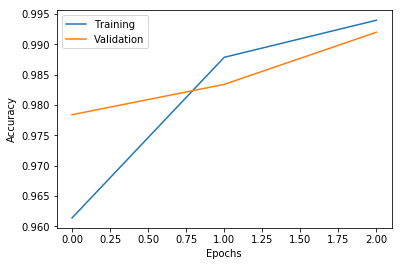

In [3]:
plt.plot(training_acc, label="Training")
plt.xlabel("Epochs")
plt.plot(validation_acc, label="Validation")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Testing Phase

In [4]:
X_TEST_TOTAL = mnist.test.images.shape[0]
TEST_BATCH_SIZE = 100
TEST_TOTAL_BATCHES = int(X_TEST_TOTAL/TEST_BATCH_SIZE)

with tf.Session() as sess:
    
    sess.run(init)
    
    CNN_SAVER.restore(sess, save_path)
    print("Model restored in file: {}".format(save_path))
    test_total_acc = 0
    start_time = time.time()

    for test_minibatch_number in range(TEST_TOTAL_BATCHES):

        X_minibatch = mnist.test.images[test_minibatch_number*TEST_BATCH_SIZE:(test_minibatch_number+1)*TEST_BATCH_SIZE]
        Y_minibatch = mnist.test.labels[test_minibatch_number*TEST_BATCH_SIZE:(test_minibatch_number+1)*TEST_BATCH_SIZE]

        minibatch_acc = sess.run(accuracy, 
                          feed_dict={
                              images_placeholder: X_minibatch,
                              labels_placeholder: Y_minibatch,
                              is_training_placeholder: False
                          })

        test_total_acc+=minibatch_acc
        
        if test_minibatch_number % 10 == 0:
            print("MB INDEX {}".format(test_minibatch_number))

    print("TEST ACC: {:.2f} | TIME {:.2f} secs".format(test_total_acc * 1.0/TEST_TOTAL_BATCHES, time.time() - start_time))

NameError: name 'CNN_SAVER' is not defined